# Style Transfer Visualization

Author: YinTaiChen

## Packages

In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os

## Cuda

In [2]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [3]:
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


## Load images

In [4]:
imsize = 512

loader = transforms.Compose([
    transforms.RandomCrop(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

style_img = image_loader("starry_night.jpg").type(dtype)
content_img = image_loader("Lenna.png").type(dtype)

## Display images

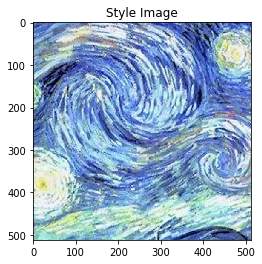

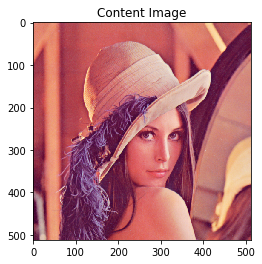

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img.data, title="Style Image")

plt.figure()
imshow(content_img.data, title="Content Image")

## Content loss

In [6]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Style loss

In [7]:
class GramMatrix(nn.Module):
    
    def forward(self, input):
        a, b, c, d = input.size()
        
        features = input.view(a * b, c * d)
        
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Load the neural network

In [9]:
cnn = models.vgg19(pretrained=True).features

if use_cuda:
    cnn = cnn.cuda()

In [15]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, style_img, content_img, style_weight=1000, content_weight=1,
                         content_layers=content_layers_default,
                         style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    style_losses = []
    content_losses = []
    
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature, style_weight)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            i += 1
            
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
    return model, style_losses, content_losses

## Input image

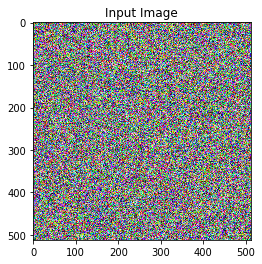

In [11]:
input_img = Variable(torch.randn(style_img.data.size())).type(dtype)

plt.figure()
imshow(input_img.data, title='Input Image')

## Gradient descent

In [12]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [17]:
def run_style_reconstruction(cnn, content_img, style_img, input_img, num_steps=300,
                            style_weight=1000, content_weight=1):
    print('Building the content reconstruction model...')
    model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing...')
    
    # Create folder
    if not os.path.exists('transfer'):
        os.makedirs('transfer')
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # Save modified input_img
            to_save = unloader(input_param.data.clone().cpu().view(3, 512, 512))
            to_save.save('./transfer/'+str(run[0])+'.jpg')
            
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.data[0], content_score.data[0]))
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    input_param.data.clamp_(0, 1)
    
    return input_param.data

In [18]:
output = run_style_reconstruction(cnn, content_img, style_img, input_img)

Building the content reconstruction model...
Optimizing...
run [50]:
Style Loss: 11.116323 Content Loss: 6.028843

run [100]:
Style Loss: 3.363733 Content Loss: 4.737481

run [150]:
Style Loss: 2.371247 Content Loss: 3.671573

run [200]:
Style Loss: 1.481091 Content Loss: 2.984983

run [250]:
Style Loss: 0.711159 Content Loss: 2.682408

run [300]:
Style Loss: 0.334370 Content Loss: 2.531818



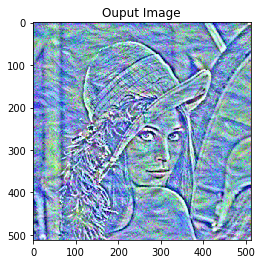

In [19]:
plt.figure()
imshow(output, title='Ouput Image')

plt.ioff()
plt.show()

## Generate GIF

In [20]:
import imageio

In [21]:
images = []
for i in range(320):
    filename = "./transfer/"+str(i)+".jpg"
    if i % 10 == 0:
        images.append(imageio.imread(filename))
imageio.mimsave('style_transfer.gif', images)